In [1]:
!pip install tensorflow

In [2]:
conda create --name sitk python=3.11 simpleitk --channel conda-forge --override-channels
conda activate sitk

SyntaxError: invalid syntax (1609653163.py, line 1)

In [3]:
!pip install scipy

In [5]:
#Libraries needed
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np
import pandas as pd
import SimpleITK as sitk
from matplotlib import pyplot as plt
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage
import math
from skimage.filters import threshold_mean
import cv2

C:\Users\clarynse\AppData\Local\Temp\ipykernel_8424\2542341768.py:8: DeprecationWarning: Please import `map_coordinates` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import map_coordinates
C:\Users\clarynse\AppData\Local\Temp\ipykernel_8424\2542341768.py:9: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [7]:
#Reading Nifti Image
#Using SimpleITK for most tasks
# Reading- Image

ct_path='Dataset002_ThyroidSeg/imagesTr/case_001_0000.nrrd'
ct_label_path='Dataset002_ThyroidSeg/labelsTr/case_001.nrrd'

# CT
img_sitk  = sitk.ReadImage(ct_path, sitk.sitkFloat32) # Reading CT
image     = sitk.GetArrayFromImage(img_sitk) #Converting sitk_metadata to image Array
# Mask
mask_sitk = sitk.ReadImage(ct_label_path,sitk.sitkInt32) # Reading CT
mask      = sitk.GetArrayFromImage(mask_sitk)#Converting sitk_metadata to image Array

print('CT Shape={}'.format(image.shape))
print('CT Mask Shape={}'.format(mask.shape))


CT Shape=(202, 1024, 1024)
CT Mask Shape=(202, 1024, 1024)


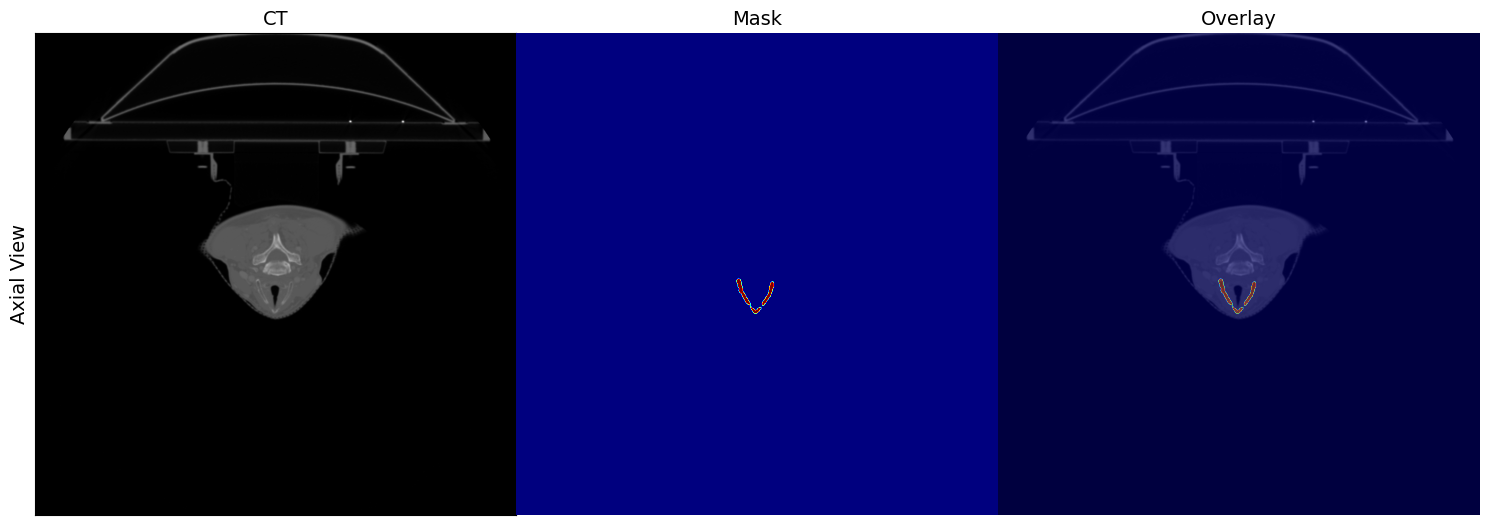

In [11]:
f, axarr = plt.subplots(1, 3, figsize=(15, 15))
slice_idx = image.shape[0] // 2  # Pick middle slice

axarr[0].imshow(np.squeeze(image[76, :, :]), cmap='gray', origin='lower')
axarr[0].set_ylabel('Axial View', fontsize=14)
axarr[0].set_xticks([])
axarr[0].set_yticks([])
axarr[0].set_title('CT', fontsize=14)

axarr[1].imshow(np.squeeze(mask[76, :, :]), cmap='jet', origin='lower')
axarr[1].axis('off')
axarr[1].set_title('Mask', fontsize=14)

axarr[2].imshow(np.squeeze(image[76, :, :]), cmap='gray', alpha=1, origin='lower')
axarr[2].imshow(np.squeeze(mask[76, :, :]), cmap='jet', alpha=0.5, origin='lower')
axarr[2].axis('off')
axarr[2].set_title('Overlay', fontsize=14)

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

In [13]:
#Intensity Normalization
def normalise(image):
    # normalise and clip images -1000 to 800
    np_img = image
    np_img = np.clip(np_img, -1000., 800.).astype(np.float32)
    return np_img


def whitening(image):
    """Whitening. Normalises image to zero mean and unit variance."""

    image = image.astype(np.float32)

    mean = np.mean(image)
    std = np.std(image)

    if std > 0:
        ret = (image - mean) / std
    else:
        ret = image * 0.
    return ret


def normalise_zero_one(image):
    """Image normalisation. Normalises image to fit [0, 1] range."""

    image = image.astype(np.float32)

    minimum = np.min(image)
    maximum = np.max(image)

    if maximum > minimum:
        ret = (image - minimum) / (maximum - minimum)
    else:
        ret = image * 0.
    return ret


def normalise_one_one(image):
    """Image normalisation. Normalises image to fit [-1, 1] range."""

    ret = normalise_zero_one(image)
    ret *= 2.
    ret -= 1.
    return ret



Normalize_minun100_to_800hu=normalise(image)
Normalize_0mean_UnitVr=whitening(image)
Normalize_0to1=normalise_zero_one(image)
normalise_minus1_to1=normalise_one_one(image)

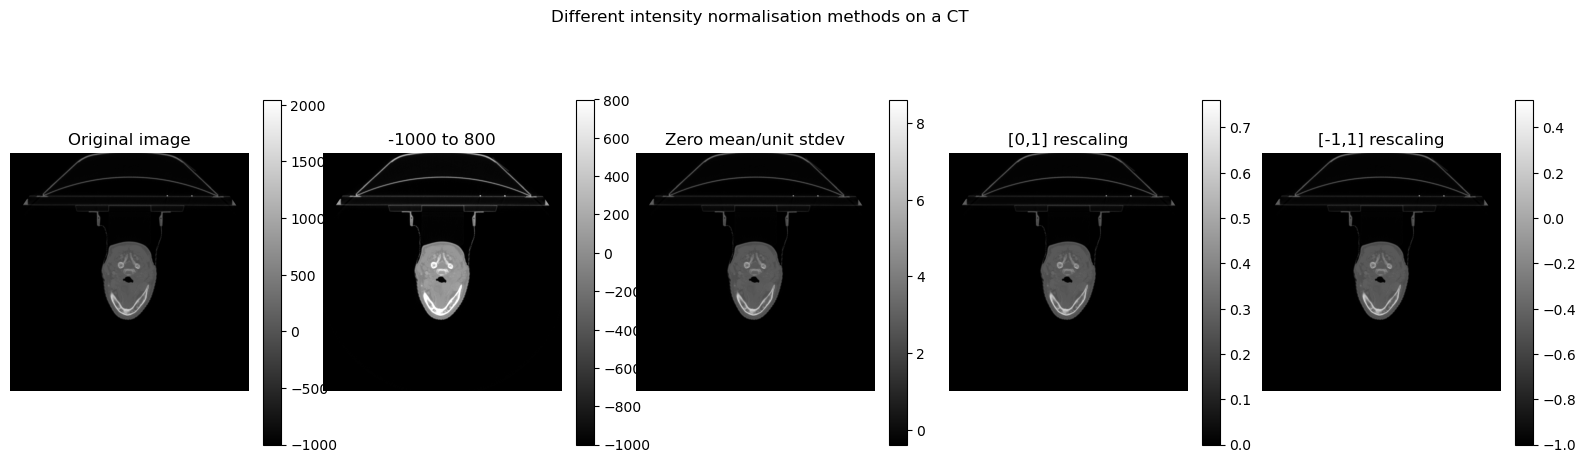

In [21]:
#Different normalization methods on CT 

f, axarr = plt.subplots(1, 5, figsize=(20,5));
f.suptitle('Different intensity normalisation methods on a CT')

img = axarr[0].imshow(np.squeeze(image[slice_idx, :, :]), cmap='gray',origin='lower');
axarr[0].axis('off')
axarr[0].set_title('Original image')
f.colorbar(img, ax=axarr[0])

img = axarr[1].imshow(np.squeeze(Normalize_minun100_to_800hu[slice_idx, :, :]), cmap='gray',origin='lower');
axarr[1].axis('off')
axarr[1].set_title('-1000 to 800')
f.colorbar(img, ax=axarr[1])

img = axarr[2].imshow(np.squeeze(Normalize_0mean_UnitVr[slice_idx, :, :]), cmap='gray',origin='lower');
axarr[2].axis('off')
axarr[2].set_title('Zero mean/unit stdev')
f.colorbar(img, ax=axarr[2])

img = axarr[3].imshow(np.squeeze(Normalize_0to1[slice_idx, :, :]), cmap='gray',origin='lower');
axarr[3].axis('off')
axarr[3].set_title('[0,1] rescaling')
f.colorbar(img, ax=axarr[3])

img = axarr[4].imshow(np.squeeze(normalise_minus1_to1[slice_idx, :, :]), cmap='gray',origin='lower');
axarr[4].axis('off')
axarr[4].set_title('[-1,1] rescaling')
f.colorbar(img, ax=axarr[4])
    
f.subplots_adjust(wspace=0.05, hspace=0, top=0.8)
plt.show();

In [23]:
#Resampling
def resample_img(itk_image, out_spacing=[2.0, 2.0, 2.0], is_label=False):
    # resample images to 2mm spacing with simple itk

    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)


ct_resampled_to1m=resample_img(img_sitk, out_spacing=[1, 1, 1], is_label=False)
ct_resampled_to1m=sitk.GetArrayFromImage(ct_resampled_to1m)
mask_resampled_to1m=resample_img(mask_sitk, out_spacing=[1, 1, 1], is_label=True)
mask_resampled_to1m=sitk.GetArrayFromImage(mask_resampled_to1m)
print('CT Shape Original={}, Resampled to 1mm={}'.format(image.shape,ct_resampled_to1m.shape))
print('CT Mask Shape={}, Resampled to 1mm={}'.format(mask.shape,mask_resampled_to1m.shape))


CT Shape Original=(202, 1024, 1024), Resampled to 1mm=(404, 571, 571)
CT Mask Shape=(202, 1024, 1024), Resampled to 1mm=(404, 571, 571)


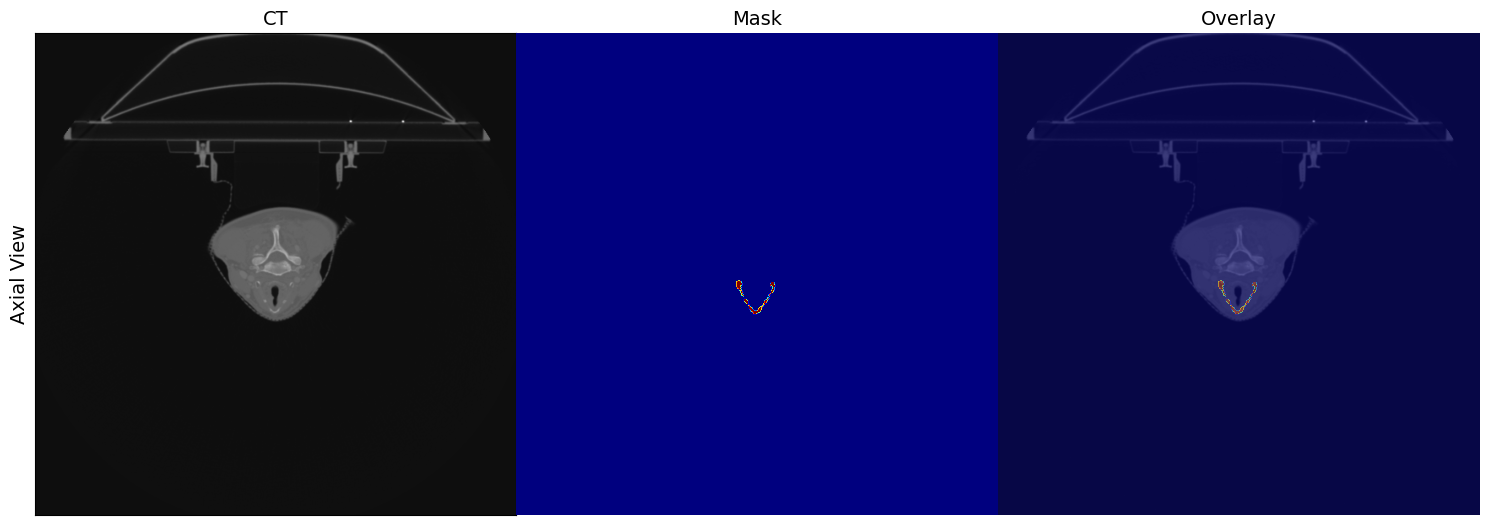

In [29]:
#Plotting 
f, axarr = plt.subplots(1,3,figsize=(15,15))
axarr[0].imshow(np.squeeze(ct_resampled_to1m[156, :, :]), cmap='gray',origin='lower');
axarr[0].set_ylabel('Axial View',fontsize=14)
axarr[0].set_xticks([])
axarr[0].set_yticks([])
axarr[0].set_title('CT',fontsize=14)

axarr[1].imshow(np.squeeze(mask_resampled_to1m[156, :, :]), cmap='jet',origin='lower');
axarr[1].axis('off')
axarr[1].set_title('Mask',fontsize=14)

axarr[2].imshow(np.squeeze(ct_resampled_to1m[156, :, :]), cmap='gray',alpha=1,origin='lower');
axarr[2].imshow(np.squeeze(mask_resampled_to1m[156, :, :]),cmap='jet',alpha=0.5,origin='lower');
axarr[2].axis('off')
axarr[2].set_title('Overlay',fontsize=14)
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

In [41]:
#Crop or padding
import numpy as np

def resize_image_with_crop_or_pad(image, img_size=(128, 128, 128), **kwargs):
    """Resizes image by cropping or padding dimensions to fit specified size.
    
    Args:
        image (np.ndarray): Input image to be resized.
        img_size (tuple or list): Target image size (Depth, Height, Width).
        kwargs: Additional arguments for np.pad.
    
    Returns:
        np.ndarray: Resized image.
    """

    assert isinstance(image, np.ndarray), "Input must be a numpy array."
    assert (image.ndim == len(img_size)), "Mismatch between image dimensions and target size."

    # Number of dimensions
    rank = len(img_size)

    # Define cropping indices and padding sizes
    from_indices = [[0, min(image.shape[dim], img_size[dim])] for dim in range(rank)]
    to_padding = [[0, 0] for dim in range(rank)]

    slicer = [slice(None)] * rank  # Default slicer (no cropping initially)

    for i in range(rank):
        if image.shape[i] < img_size[i]:  # Padding needed
            to_padding[i][0] = max(0, (img_size[i] - image.shape[i]) // 2)
            to_padding[i][1] = max(0, img_size[i] - image.shape[i] - to_padding[i][0])
        else:  # Cropping needed
            from_indices[i][0] = max(0, (image.shape[i] - img_size[i]) // 2)
            from_indices[i][1] = from_indices[i][0] + img_size[i]

        slicer[i] = slice(from_indices[i][0], from_indices[i][1])

    # Perform cropping
    cropped_image = image[tuple(slicer)]

    # Perform padding if needed
    if any(any(pad > 0 for pad in pad_pair) for pad_pair in to_padding):
        cropped_image = np.pad(cropped_image, to_padding, **kwargs)

    return cropped_image

# Example usage:
# Ensure `image` is a valid numpy array before calling
# Cropping example: Resize image to [256, 256, 256], mode='symmetric')
img_cropped = resize_image_with_crop_or_pad(image, [256, 256, 256], mode='symmetric')

# Padding example: Resize image to [512, 512, 512]
img_padded = resize_image_with_crop_or_pad(image, [512, 512, 512], mode='symmetric')


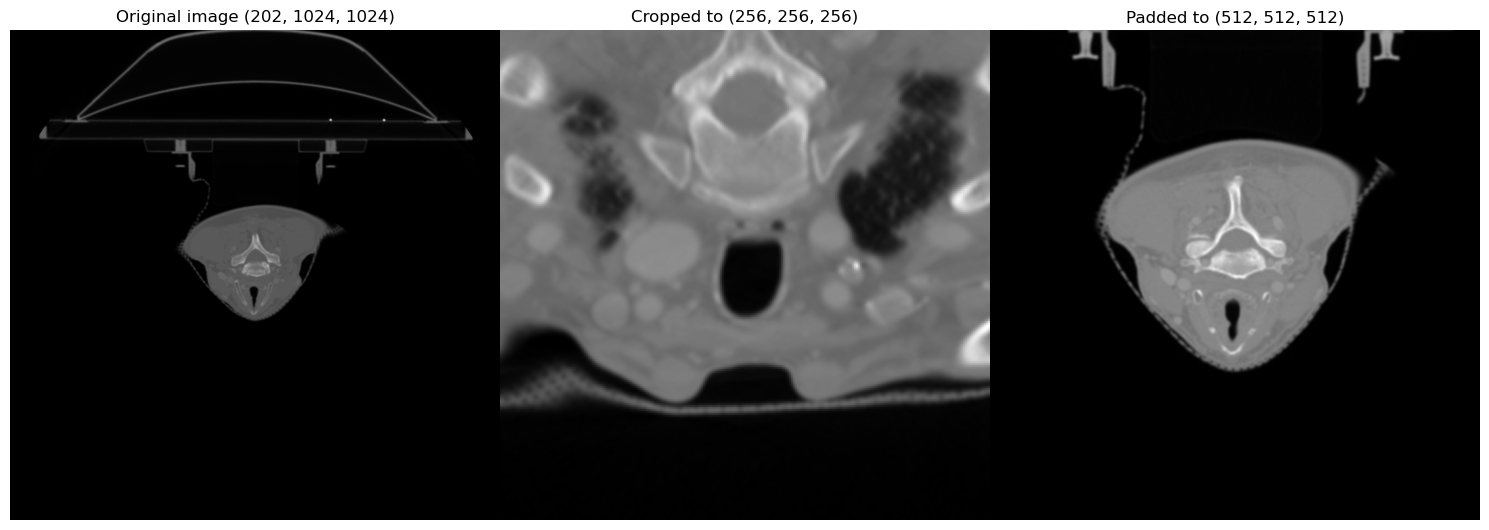

In [43]:
# Visualise using matplotlib.
f, axarr = plt.subplots(1, 3, figsize=(15,15));
axarr[0].imshow(np.squeeze(image[76, :, :]), cmap='gray',origin='lower');
axarr[0].axis('off')
axarr[0].set_title('Original image {}'.format(image.shape))

axarr[1].imshow(np.squeeze(img_cropped[76, :, :]), cmap='gray',origin='lower');
axarr[1].axis('off')
axarr[1].set_title('Cropped to {}'.format(img_cropped.shape))

axarr[2].imshow(np.squeeze(img_padded[76, :, :]), cmap='gray',origin='lower');
axarr[2].axis('off')
axarr[2].set_title('Padded to {}'.format(img_padded.shape))
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)